In [214]:
#load path
import os
import sys
import astropy
from astropy.io import fits
from astropy.table import QTable

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder
from astropy.modeling import models, fitting
from photutils.psf.matching import create_matching_kernel
from photutils.psf.matching import TopHatWindow, HanningWindow
from astropy.convolution import convolve_fft


from astropy.wcs import WCS
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus, ApertureStats
from astropy.stats import SigmaClip

from astropy.visualization import (ImageNormalize, MinMaxInterval,PercentileInterval,SqrtStretch)
import glob

import warnings


In [176]:
path='./data/'
rawpath=r'/Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/'
calibpath='./data/Calibs/'
reduxpath='./data/Redux/'
combinepath='./data/Redux/Combined/'
gain=0.25 #e-/ADU at G = 125

Coadding

In [177]:
def measure_fwhm(data, oversampling=1):
    """
    Fits a 2D Gaussian to the data and returns the FWHM in native pixels.
    """
    # Define a grid of coordinates
    y, x = np.mgrid[:data.shape[0], :data.shape[1]]

    # accurate center estimate
    x_cen, y_cen = data.shape[1] // 2, data.shape[0] // 2

    # Initialize a 2D Gaussian model
    g_init = models.Gaussian2D(
        amplitude=np.max(data),
        x_mean=x_cen,
        y_mean=y_cen,
        x_stddev=2,  # initial guess
        y_stddev=2
    )

    # Fit the model to the data
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, x, y, data)

    # Calculate FWHM (FWHM = 2.355 * sigma)
    # We take the average of x and y sigma for circular approximation
    sigma_avg = np.min((g.x_stddev.value,g.y_stddev.value))
    axis_ratio = np.max((g.x_stddev.value,g.y_stddev.value)) / np.min((g.x_stddev.value,g.y_stddev.value))
    fwhm_model_pixels = sigma_avg * 2.35482

    # Convert to native image pixels
    fwhm_native = fwhm_model_pixels / oversampling * 0.55

    return fwhm_native, axis_ratio

In [178]:
def build_epfs(image):

    from photutils.detection import find_peaks
    peaks_tbl = find_peaks(image, threshold=25.0)
    peaks_tbl['peak_value'].info.format = '%.8g'
    print('Number of stars found: {}'.format(len(peaks_tbl)))

    size = 31
    hsize = (size - 1) / 2
    x = peaks_tbl['x_peak']
    y = peaks_tbl['y_peak']
    sat = []
    for ii in range(len(x)):
        sat.append(np.sum(image[int(y[ii]-hsize):int(y[ii]+hsize), int(x[ii]-hsize):int(x[ii]+hsize)]))

    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) & (y > hsize) & (y < (data.shape[0] -1 - hsize)) & np.isfinite(sat))

    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]

    print('Number of good stars used for EPSF: {}'.format(len(stars_tbl)))

    nddata = NDData(data=image)
    stars = extract_stars(nddata, stars_tbl, size=size)

    #nrows = 5
    #ncols = 5
    #fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),squeeze=True)
    #ax = ax.ravel()
    #for i in range(nrows * ncols):
    #    norm = simple_norm(stars[i], 'log', percent=99.0)
    #    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

    psf_builder = EPSFBuilder(oversampling=1, maxiters=3,progress_bar=False)
    epsf, fitted_stars = psf_builder(stars)

    #from astropy.visualization import simple_norm
    #norm = simple_norm(epsf.data, 'log', percent=99.0)
    #plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    #plt.colorbar()

    epsfimage = epsf.data

    fwhm, axis_ratio = measure_fwhm(epsfimage) #fwhm is in arcsec

    return epsfimage, fwhm, axis_ratio


In [179]:
#test the epfs code
#ima = fits.open(combinepath+'/Combined_NGC6946_R.fits')[0].data
#eat1, eat2, eat3 = build_epfs(ima)

In [218]:
import glob
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
import numpy as np

# List of filters to process
filters = ['R','G','I','SII','OIII','Ha','Hb']
targname = 'NGC7331' #'PSZ2G114.79-33.71'
outsize = 4500

for filter in filters:
    # Find all sky-subtracted images for this filter
    images = glob.glob(reduxpath + f'/*{targname}_{filter}*sky_sub.fits')
    if len(images) == 0:
        print('No images found')
        continue
    else:
        print(f'Processing {len(images)} images for filter {filter}')

    #Generate an header of 5000x5000 pixels with WCS centered on the target and pixel scale of 0.55 arcsec/pixel
    # Use the first image as reference
    ref_hdu = fits.open(images[0])
    ref_data = ref_hdu[0].data
    ref_header = ref_hdu[0].header

    out_header = fits.Header()
    for key in ['CTYPE1','CTYPE2','CRVAL1','CRVAL2','CRPIX1','CRPIX2','CD1_1','CD1_2','CD2_1','CD2_2','FUNIT','EXPTIME']:
        out_header[key] = ref_header[key]


    from astroquery.simbad import Simbad
    result_table = Simbad.query_object(targname)
    if result_table is None:
        print('Could not find target {} in Simbad, using default RA and DEC'.format(targname))
    else:
        print('Query succeeded for target {}'.format(targname))
        try:
         #Find object RA and DEC
         center_ra = result_table['ra'][0]
         center_dec = result_table['dec'][0]
         print('Target coordinates: {:7.4f} - {:7.4f} '.format(center_ra, center_dec))
         out_header['CTYPE1'] = 'RA---TAN'
         out_header['CTYPE2'] = 'DEC--TAN'
         out_header['CRVAL1'] = center_ra
         out_header['CRVAL2'] = center_dec
         out_header['CRPIX1'] = outsize/2.
         out_header['CRPIX2'] = outsize/2.
         out_header['CD1_1'] = -0.0001527778
         out_header['CD2_2'] = 0.0001527778
         out_header['CD1_2'] = 0
         out_header['CD2_1'] = 0
         ref_data = np.zeros((outsize,outsize))
        except:
         print('Could not find target {} in Simbad, using default RA and DEC'.format(targname))

    out_wcs = WCS(out_header)
    stack = []

    for img in images:
      with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        hdu = fits.open(img)
        print('  Now reading: {}'.format(img))
        data = hdu[0].data
        mask = hdu[1].data
        data[mask>0] = np.nan
        header = hdu[0].header
        wcs = WCS(header)
        exptime = hdu[0].header['EXPTIME']
        if exptime<30:
            print(f'  Skipping image {img} with exptime {exptime}s')
            continue
        # Reproject to reference WCS
        reproj_data, _ = reproject_interp((data, wcs), out_wcs, shape_out=ref_data.shape, parallel=4)
        stack.append(reproj_data)

    # Combine (with sigma clipped mean statistics)
    print('Stacking ....')
    stack = np.array(stack)
    clip = sigma_clip(stack, axis=0, masked=False)
    combined = np.nanmean(clip, axis=0)
    combvar  = np.nanvar(clip, axis=0)

    epsf, fwhm, axrat = build_epfs(combined)

    out_header['PSFFWHM'] = fwhm
    out_header['PSFAXRAT'] = axrat

    # Save combined image and uncertainty
    hdu1 = fits.PrimaryHDU(combined, out_header)
    hdu2 = fits.ImageHDU(combvar, out_header)
    hdu3 = fits.ImageHDU(epsf, out_header)
    hduout = fits.HDUList([hdu1, hdu2, hdu3])

    hduout.writeto(combinepath + f'/Combined_{targname}_{filter}.fits', overwrite=True)

Processing 33 images for filter R
Query succeeded for target NGC7331
Target coordinates: 339.2669 - 34.4158 
  Now reading: ./data/Redux/2025-11-03_22-15-34_sci_NGC7331_R_exp300.00_0003_sky_sub.fits
  Now reading: ./data/Redux/2025-10-10_20-55-47_sci_NGC7331_R_exp300.00_0003_sky_sub.fits
  Now reading: ./data/Redux/2025-10-10_20-18-31_sci_NGC7331_R_exp300.00_0003_sky_sub.fits
  Now reading: ./data/Redux/2025-11-05_23-58-30_sci_NGC7331_R_exp300.00_0000_sky_sub.fits
  Now reading: ./data/Redux/2025-10-10_20-44-14_sci_NGC7331_R_exp300.00_0001_sky_sub.fits
  Now reading: ./data/Redux/2025-11-04_20-31-45_sci_NGC7331_R_exp300.00_0002_sky_sub.fits
  Now reading: ./data/Redux/2025-11-05_23-19-18_sci_NGC7331_R_exp300.00_0001_sky_sub.fits
  Now reading: ./data/Redux/2025-10-26_21-13-14_sci_NGC7331_R_exp300.00_0002_sky_sub.fits
  Now reading: ./data/Redux/2025-11-03_22-09-31_sci_NGC7331_R_exp300.00_0002_sky_sub.fits
  Now reading: ./data/Redux/2025-11-04_20-20-55_sci_NGC7331_R_exp300.00_0000_sky_

/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_60204/1278123065.py:82: RuntimeWarning: Mean of empty slice
  combined = np.nanmean(clip, axis=0)
/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_60204/1278123065.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  combvar  = np.nanvar(clip, axis=0)


Number of stars found: 133
Number of good stars used for EPSF: 45
Processing 7 images for filter G
Query succeeded for target NGC7331
Target coordinates: 339.2669 - 34.4158 
  Now reading: ./data/Redux/2025-10-09_19-08-28_sci_NGC7331_G_exp600.00_0000_sky_sub.fits
  Now reading: ./data/Redux/2025-11-18_19-00-33_sci_NGC7331_G_exp300.00_0005_sky_sub.fits
  Now reading: ./data/Redux/2025-11-18_18-49-28_sci_NGC7331_G_exp300.00_0003_sky_sub.fits
  Now reading: ./data/Redux/2025-11-18_18-44-01_sci_NGC7331_G_exp300.00_0002_sky_sub.fits
  Now reading: ./data/Redux/2025-11-18_18-32-56_sci_NGC7331_G_exp300.00_0000_sky_sub.fits
  Now reading: ./data/Redux/2025-11-18_18-55-32_sci_NGC7331_G_exp300.00_0004_sky_sub.fits
  Now reading: ./data/Redux/2025-11-18_18-37-57_sci_NGC7331_G_exp300.00_0001_sky_sub.fits
Stacking ....


/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_60204/1278123065.py:82: RuntimeWarning: Mean of empty slice
  combined = np.nanmean(clip, axis=0)
/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_60204/1278123065.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  combvar  = np.nanvar(clip, axis=0)


Number of stars found: 172
Number of good stars used for EPSF: 54
No images found
No images found
No images found
Processing 19 images for filter Ha
Query succeeded for target NGC7331
Target coordinates: 339.2669 - 34.4158 
  Now reading: ./data/Redux/2025-10-18_20-29-07_sci_NGC7331_Ha_exp1200.00_0002_sky_sub.fits
  Now reading: ./data/Redux/2025-11-03_21-34-12_sci_NGC7331_Ha_exp1200.00_0003_sky_sub.fits
  Now reading: ./data/Redux/2025-11-04_19-59-48_sci_NGC7331_Ha_exp1200.00_0002_sky_sub.fits
  Now reading: ./data/Redux/2025-11-05_22-48-31_sci_NGC7331_Ha_exp1200.00_0001_sky_sub.fits
  Now reading: ./data/Redux/2025-10-18_20-08-40_sci_NGC7331_Ha_exp1200.00_0001_sky_sub.fits
  Now reading: ./data/Redux/2025-10-18_19-48-25_sci_NGC7331_Ha_exp1200.00_0000_sky_sub.fits
  Now reading: ./data/Redux/2025-10-26_21-19-19_sci_NGC7331_Ha_exp1200.00_0000_sky_sub.fits
  Now reading: ./data/Redux/2025-11-04_19-39-33_sci_NGC7331_Ha_exp1200.00_0001_sky_sub.fits
  Now reading: ./data/Redux/2025-10-26_2

/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_60204/1278123065.py:82: RuntimeWarning: Mean of empty slice
  combined = np.nanmean(clip, axis=0)
/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_60204/1278123065.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice.
  combvar  = np.nanvar(clip, axis=0)


Number of stars found: 117
Number of good stars used for EPSF: 56
No images found


Not performing any convolution


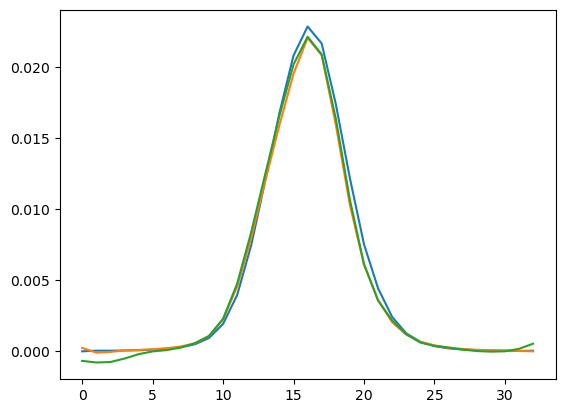

In [220]:
#For Halpha, read halpha and r band images and generate NET image

targname = 'NGC7331'

hahdu = fits.open(combinepath + '/Combined_{}_{}.fits'.format(targname,'Ha'))
haima = hahdu[0].data
hapsf = hahdu[2].data
hafwhm = hahdu[0].header['PSFFWHM']

rhdu = fits.open(combinepath + '/Combined_{}_{}.fits'.format(targname,'R'))
rima = rhdu[0].data
rpsf = rhdu[2].data
rfwhm = rhdu[0].header['PSFFWHM']

if hafwhm>1.1*rfwhm: #Need to convolve the r image (better) to match ha (worse)
  kernel = create_matching_kernel(rpsf, hapsf, window=TopHatWindow(0.55)) #source, target
  haimaconv = haima
  rimaconv = convolve_fft(rima, kernel)
elif rfwhm>1.1*hafwhm:
  kernel = create_matching_kernel(hapsf, rpsf, window=TopHatWindow(0.55)) #source, target
  haimaconv = convolve_fft(haima, kernel)
  rimaconv = rima
else:
  print('Not performing any convolution')
  haimaconv = haima
  rimaconv = rima


#plt.imshow(kernel)
#plt.show()

plt.plot(rpsf[:,16])
plt.plot(hapsf[:,16])
#plt.plot(kernel[:,16])
plt.plot(convolve(rpsf,kernel)[:,16])

netima = (haimaconv-rimaconv)*35

hduout = fits.PrimaryHDU(netima, hahdu[0].header)
hduout.writeto(combinepath + '/Combined_{}_{}.fits'.format(targname,'NET'), overwrite=True)

In [ ]:
'''
#For the students: Generate a bespoke header for the combined image
import glob
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
import numpy as np

# List of filters to process
filters = ['R','G','I','SII','OIII','Ha','Hb']
targname = 'NGC6946'
ra_cent = 308.71804
dec_cent =  60.15367
outsize = 4500

for filter in filters:
    # Find all sky-subtracted images for this filter
    images = glob.glob(reduxpath + f'/*{targname}_{filter}*sky_sub.fits')
    if len(images) == 0:
        print('No images found')
        continue
    else:
        print(f'Processing {len(images)} images for filter {filter}')

    ref_wcs = WCS(naxis=2)
    # reference value = center coordinates (deg)
    ref_wcs.wcs.crval = [ra_cent, dec_cent]
    # reference pixel = image center (1-indexed convention handled by astropy as float)
    ref_wcs.wcs.crpix = [outsize / 2.0, outsize / 2.0]
    # set projection and units
    ref_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    ref_wcs.wcs.cunit = ["deg", "deg"]

    # pixel scale in degrees
    scale_deg = 0.55 / 3600.0

    ref_wcs.wcs.cd = np.array([[-scale_deg, 0.0], [0.0, scale_deg]])

    stack = []

    for img in images:
        hdu = fits.open(img)
        data = hdu[0].data
        header = hdu[0].header
        wcs = WCS(header)
        exptime = hdu[0].header['EXPTIME']
        if exptime<30:
            print(f'Skipping image {img} with exptime {exptime}s')
            continue
        # Reproject to reference WCS
        reproj_data, _ = reproject_interp((data, wcs), ref_wcs, shape_out=ref_data.shape, parallel=4)
        stack.append(reproj_data)

    # Combine (with sigma clipped mean statistics)
    print('Stacking ....')
    stack = np.array(stack)
    clip = sigma_clip(stack, axis=0, masked=False)
    combined = np.nanmean(clip, axis=0)

    # Save combined image
    fits.writeto(combinepath + f'/Combined_{targname}_{filter}.fits', combined, ref_header, overwrite=True)
'''